In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR
from themis_ml.datasets import german_credit

from utils import convert_to_cat, one_hot_encode
from utils import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from utils import get_classification_summary, get_table_metrics, get_epsilon_plots
from utils import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in the original data
german_data = german_credit(raw=True)
german_data

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account/bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors/guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,credit_risk
0,1,6,critical_account/other_credits_existing_not_at...,radio/television,1169,0,4,4,male_single,none,...,real_estate,67,none,own,2,2,1,1,1,1
1,2,48,existing_credits_paid_back_duly_till_now,radio/television,5951,1,2,2,female_divorced/separated/married,none,...,real_estate,22,none,own,1,2,1,0,1,0
2,0,12,critical_account/other_credits_existing_not_at...,education,2096,1,3,2,male_single,none,...,real_estate,49,none,own,1,1,2,0,1,1
3,1,42,existing_credits_paid_back_duly_till_now,furniture/equipment,7882,1,3,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45,none,for free,1,2,2,0,1,1
4,1,24,delay_in_paying_off_in_the_past,car_(new),4870,1,2,3,male_single,none,...,unknown/no_property,53,none,for free,2,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,12,existing_credits_paid_back_duly_till_now,furniture/equipment,1736,1,3,3,female_divorced/separated/married,none,...,real_estate,31,none,own,1,1,1,0,1,1
996,1,30,existing_credits_paid_back_duly_till_now,car_(used),3857,1,2,4,male_divorced/separated,none,...,building_society_savings_agreement/life_insurance,40,none,own,1,3,1,1,1,1
997,0,12,existing_credits_paid_back_duly_till_now,radio/television,804,1,4,4,male_single,none,...,car_or_other,38,none,own,1,2,1,0,1,1
998,1,45,existing_credits_paid_back_duly_till_now,radio/television,1845,1,2,4,male_single,none,...,unknown/no_property,23,none,for free,1,2,1,1,1,0


In [4]:
# Get the categorical data
cat_german = convert_to_cat(german_data, dataset="german")
cat_german

,duration_in_year,credit_amount,installment_rate_in_percentage_of_disposable_income,age,credit_history,housing,status_of_existing_checking_account,present_employment_since,purpose,credit_risk
0,0,0,4,1,0,0,1,4,0,1
1,4,1,2,0,1,0,2,2,0,0
2,1,2,2,1,0,0,0,3,1,1
3,3,3,2,1,1,1,1,3,2,1
4,2,1,3,1,2,1,1,2,3,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0,3,1,1,0,0,3,2,1
996,2,1,4,1,1,0,1,2,4,1
997,1,0,4,1,1,0,0,4,0,1
998,3,0,4,0,1,1,1,2,0,0


In [5]:
# Get the one-hot encoded data
encoded_german = one_hot_encode(cat_german, dataset="german")
encoded_german

,age,credit_risk,duration_in_year_1,duration_in_year_2,duration_in_year_3,duration_in_year_4,duration_in_year_5,duration_in_year_6,credit_amount_1,credit_amount_2,...,present_employment_since_4,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
996,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
997,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_german, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_german, test_size=0.2, random_state=0)

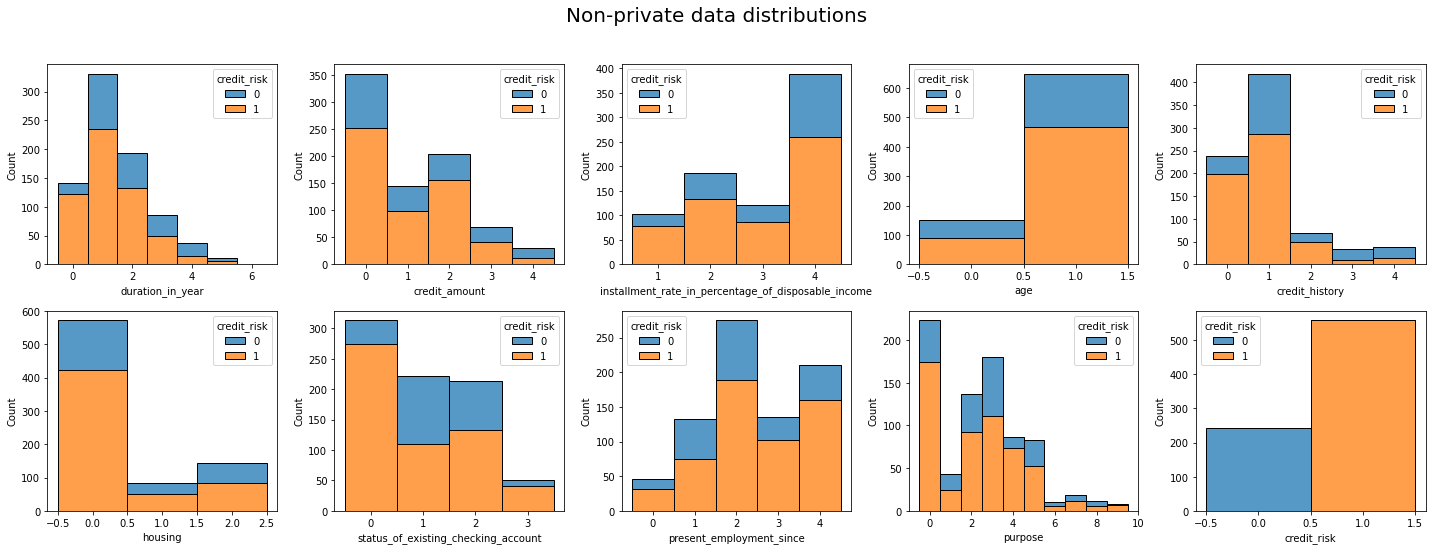

In [7]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", dataset="german")

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="german")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
<=25: 0.8500, >25: 0.8689

False positive rates:
<=25: 0.5556, >25: 0.5000

Equalized odds distances:
y=1: 0.0189, y=0: -0.0556

Classification accuracies:
<=25: 0.6579, >25: 0.7778

F1-score: 0.8339

Avg train pred: 0.7975, Avg test pred: 0.7650


In [9]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="german")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
<=25: 0.9500, >25: 0.8279

False positive rates:
<=25: 0.5556, >25: 0.5750

Equalized odds distances:
y=1: -0.1221, y=0: 0.0194

Classification accuracies:
<=25: 0.7105, >25: 0.7284

F1-score: 0.8136

Avg train pred: 0.7075, Avg test pred: 0.7650


# 3. New MWEM synthesis

In [10]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10, dataset="german", results_dir="german/")

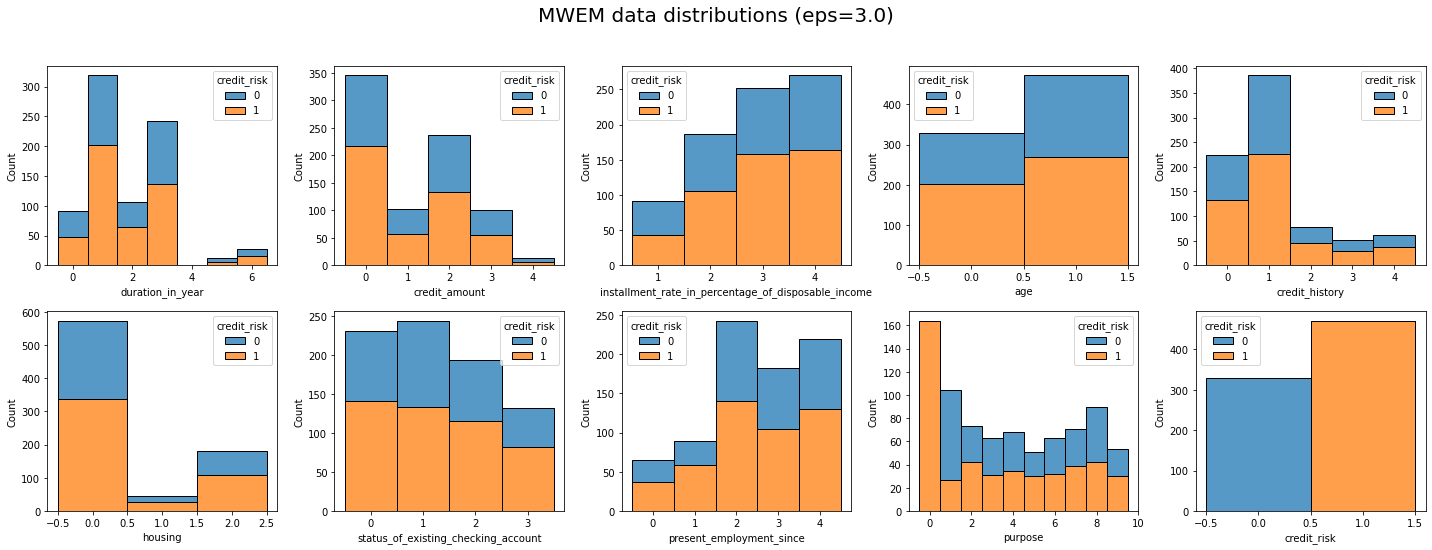

In [12]:
MWEM_eps3_rep0 = pd.read_csv("german/MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset="german")

In [13]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.085
FPR difference median: -0.086
F1-score median: 0.724


In [14]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.061
FPR difference median: -0.001
F1-score median: 0.723


# 4. New DP-CTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=10, dataset="german", results_dir="german/")

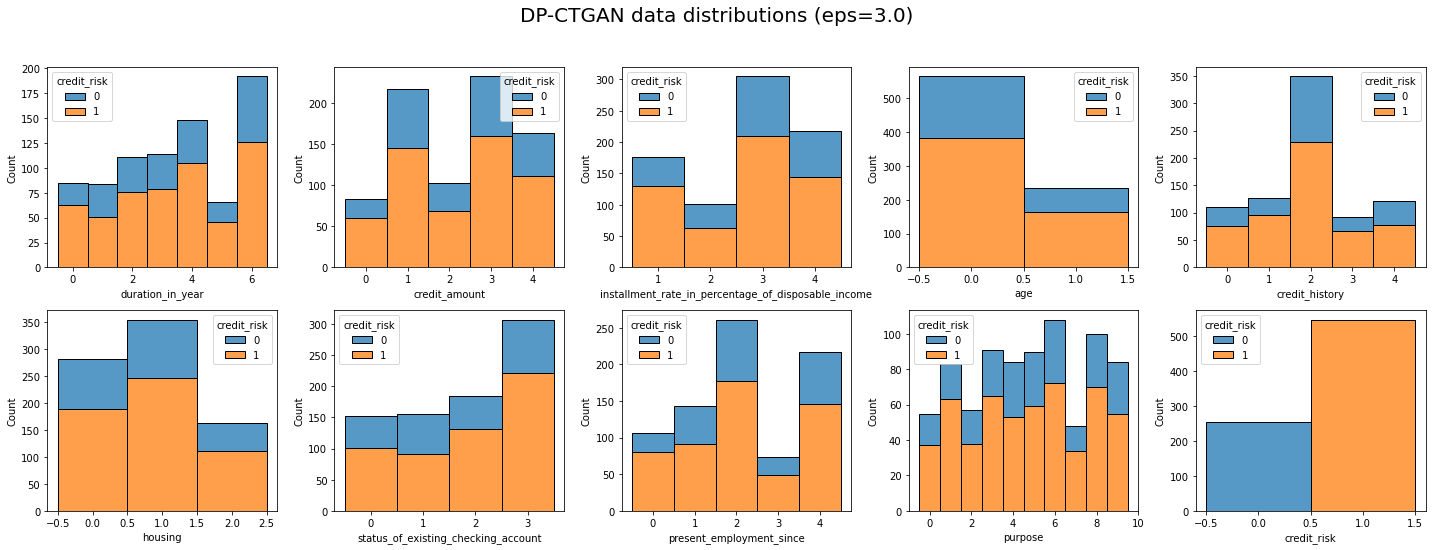

In [16]:
DPCTGAN_eps3_rep0 = pd.read_csv("german/DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset="german")

In [17]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.012
FPR difference median: -0.047
F1-score median: 0.824


In [18]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.012
FPR difference median: -0.035
F1-score median: 0.812


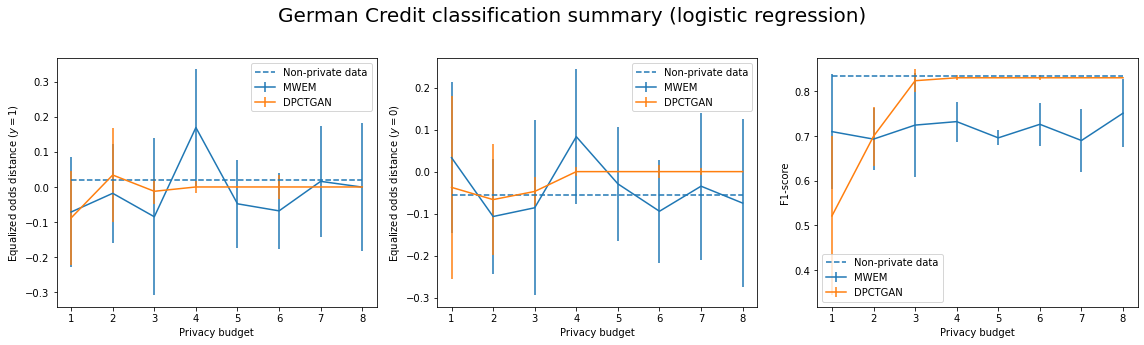

In [19]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

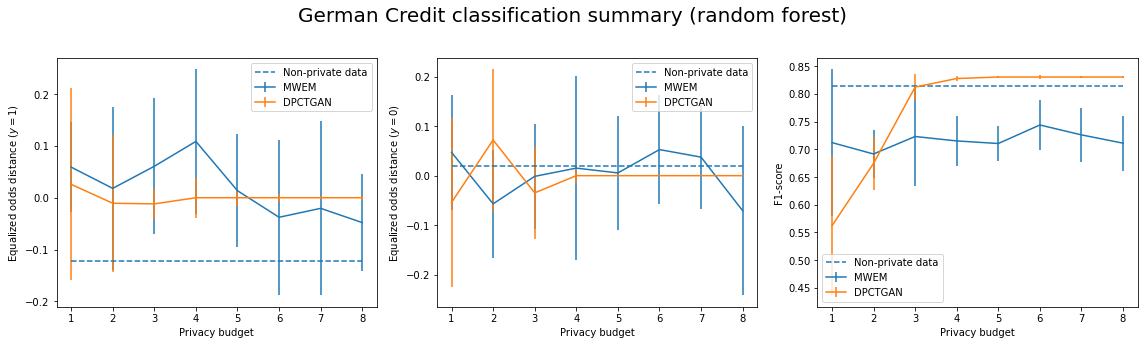

In [20]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

# 5. New PATE-CTGAN synthesis (tuning)

In [26]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with PATECTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="german", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5, results_dir="german/")

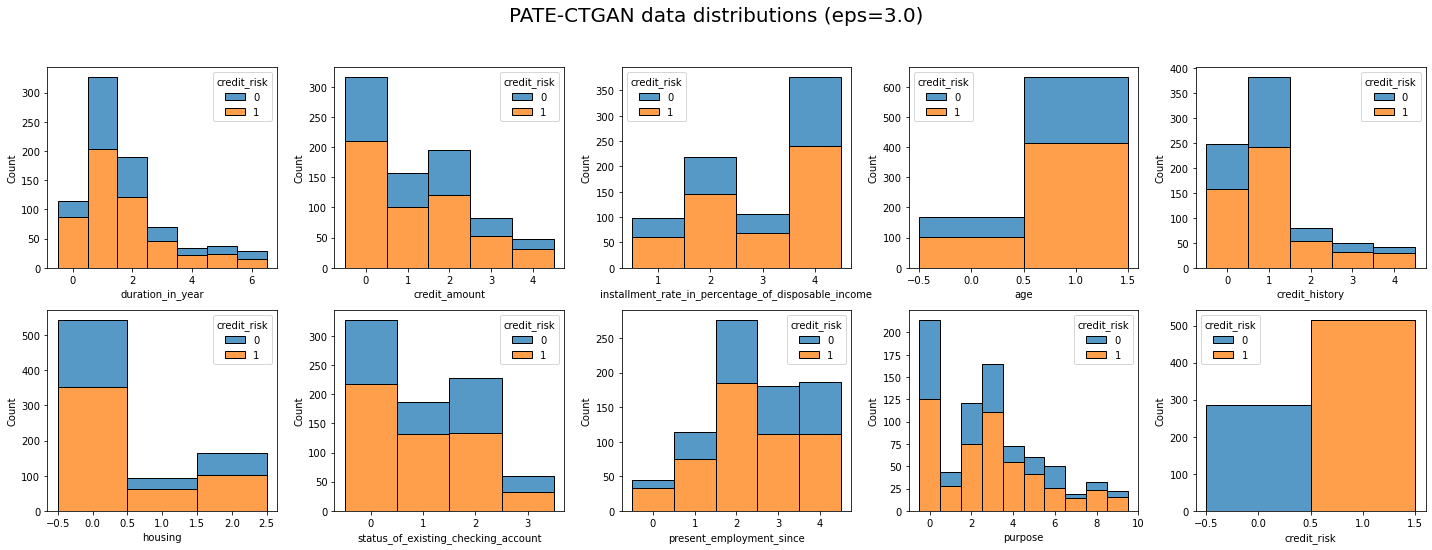

In [28]:
# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("german/PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)", dataset="german")

In [29]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.084
FPR difference median: 0.101
F1-score median: 0.822


In [30]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.177
FPR difference median: 0.001
F1-score median: 0.759


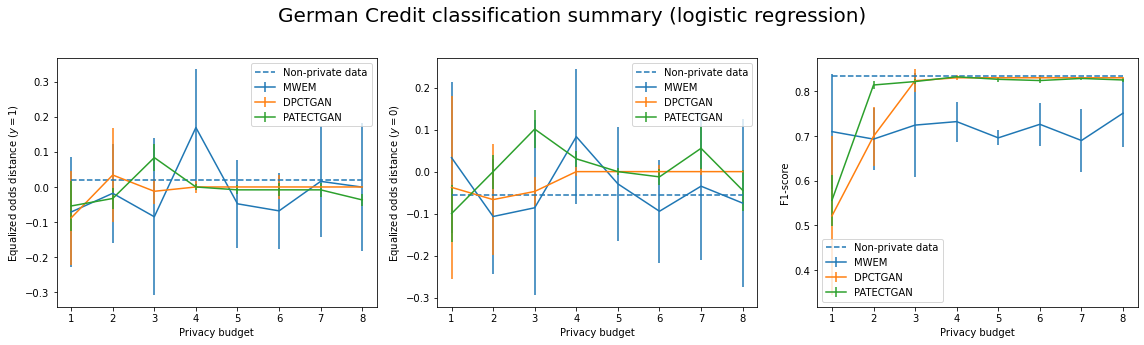

In [31]:
# Plot new MWEM, DP-CTGAN and PATE-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

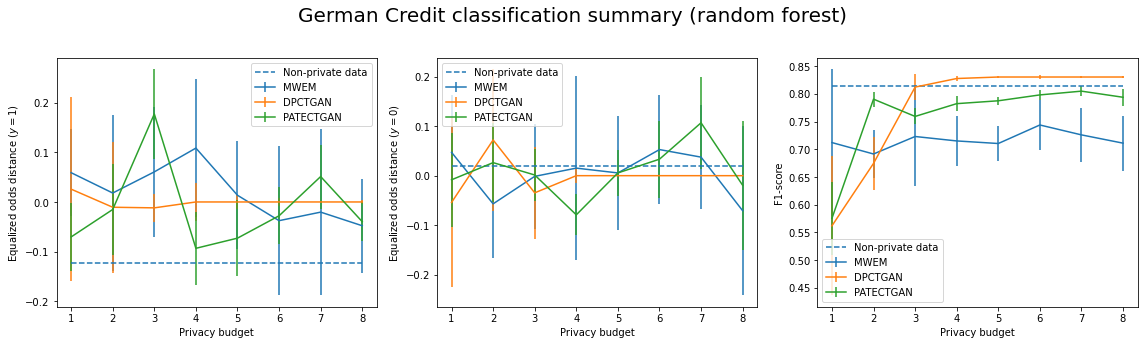

In [32]:
# Plot new MWEM, DP-CTGAN and PATE-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

# 6. New QUAIL-MWEM synthesis

In [33]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/")

In [35]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.026
FPR difference median: 0.074
F1-score median: 0.725


In [36]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.110
FPR difference median: 0.113
F1-score median: 0.735


# 7. New QUAIL-DPCTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/")

In [38]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.050
FPR difference median: -0.054
F1-score median: 0.736


In [39]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.001
FPR difference median: -0.046
F1-score median: 0.736


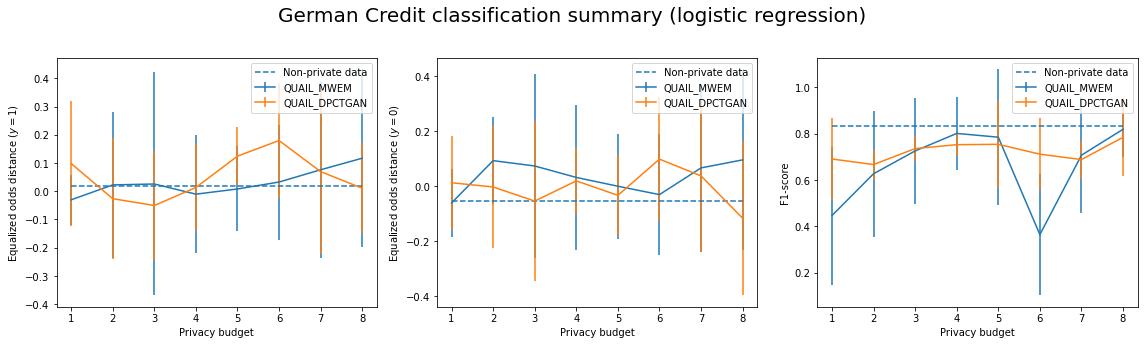

In [40]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

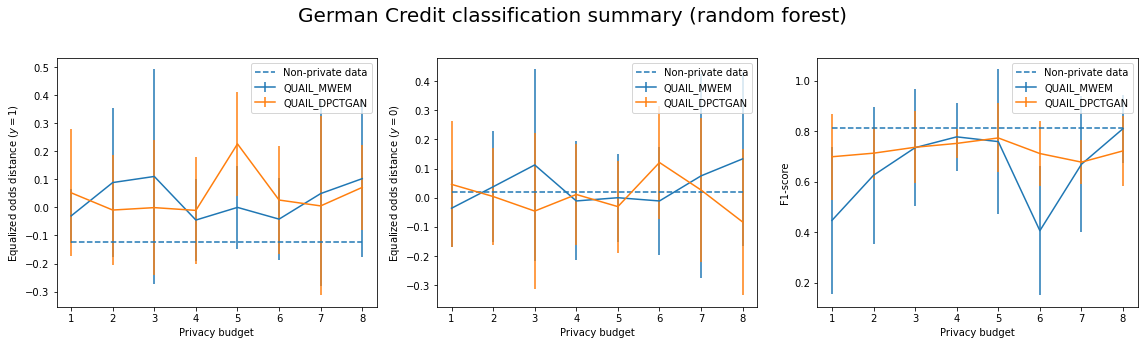

In [41]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/")

# 8. New QUAIL-PATECTGAN synthesis

In [43]:
# ValueError: Inputted epsilon parameter is too small to create a private dataset. Try increasing epsilon and rerunning.
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-PATECTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/")

In [45]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.033
FPR difference median: -0.071
F1-score median: 0.714


In [46]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.052
FPR difference median: -0.008
F1-score median: 0.744


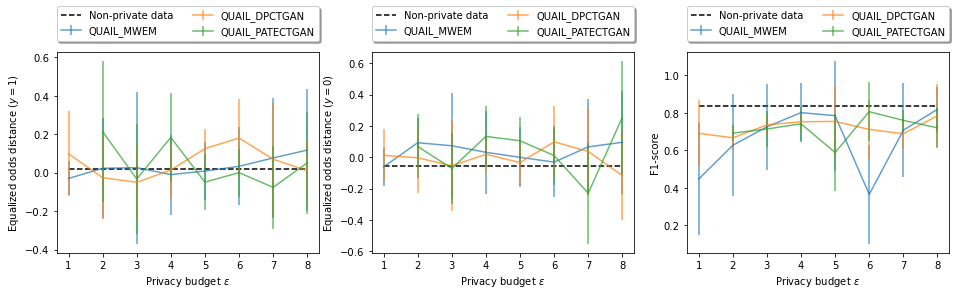

In [7]:
# Plot all results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/", savefig=True)

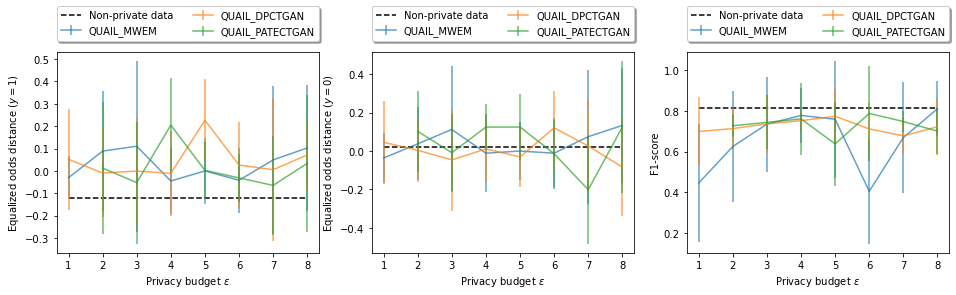

In [8]:
# Plot all results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/", savefig=True)

# 9. Comparison to DPLR

In [49]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="german")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.030
FPR difference median: 0.024
F1-score median: 0.770


# 10. Comparison to k-anonymity

In [9]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [10]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [11]:
# Specify the feature columns and label
feature_columns = ['duration_in_year', 'credit_amount', 'installment_rate_in_percentage_of_disposable_income', 
                   'age', 'credit_history', 'housing','status_of_existing_checking_account','present_employment_since', 'purpose']
sensitive_column = 'credit_risk'

# Make partitions for k=5
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=5)

# Get the number of partitions created
len(finished_partitions)

119

In [12]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...


In [13]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df, dataset="german")
kanon_df

,duration_in_year,credit_amount,installment_rate_in_percentage_of_disposable_income,age,credit_history,housing,status_of_existing_checking_account,present_employment_since,purpose,credit_risk
0,3,3,2,0,1,0,1,3,3,0
1,3,3,2,0,1,0,1,3,3,1
2,2,1,1,0,0,0,1,2,2,0
3,2,1,1,0,0,0,1,2,2,1
4,5,3,4,0,1,0,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...
213,1,0,4,1,1,0,0,4,5,0
214,1,0,4,1,1,0,0,4,5,1
215,1,0,4,1,0,0,0,2,0,1
216,1,0,4,1,0,0,0,4,0,0


In [14]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="german")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="german")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
<=25: 0.7500, >25: 0.8934

False positive rates:
<=25: 0.5556, >25: 0.8000

Equalized odds distances:
y=1: 0.1434, y=0: 0.2444

Classification accuracies:
<=25: 0.6053, >25: 0.7222

F1-score: 0.8052

Avg train pred: 0.8165, Avg test pred: 0.8300


# 11. Pre-processing (undersampling before synth)

In [15]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

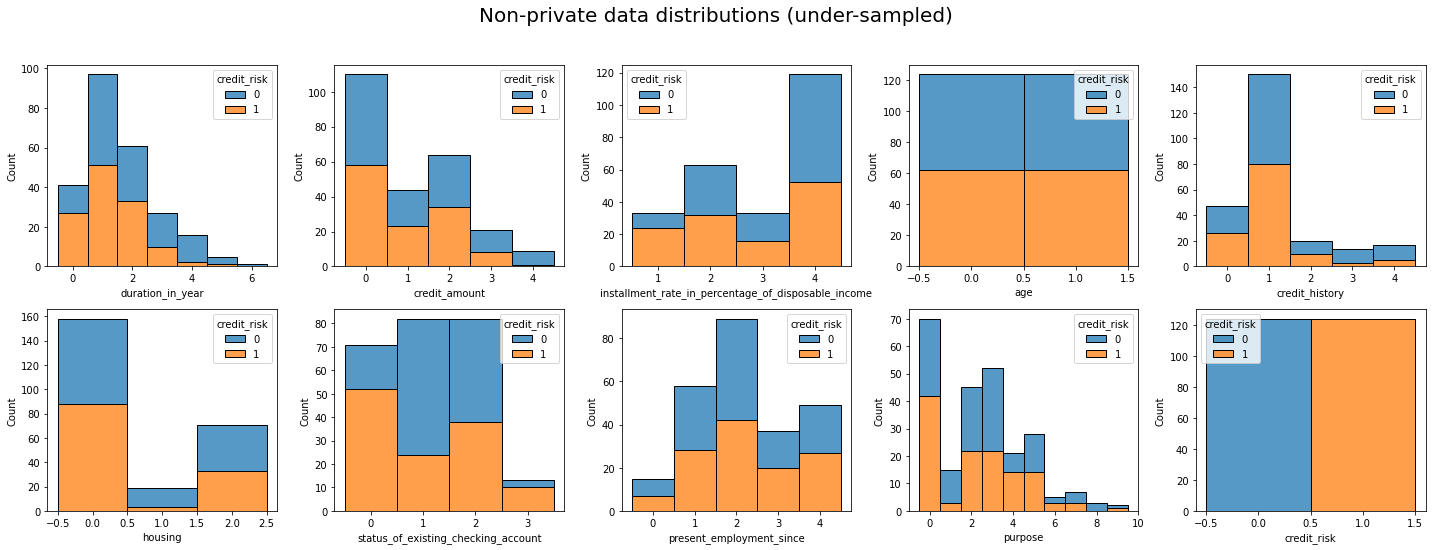

In [16]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="age", target="credit_risk")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", dataset="german")

In [17]:
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/preprocessed/")

In [18]:
# ValueError: sample_rate=2.0161290322580645 is not a valid value. Please provide a float between 0 and 1.
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/preprocessed/")

ValueError: sample_rate=2.0161290322580645 is not a valid value. Please provide a float between 0 and 1.

In [ ]:
# ValueError: sample_rate=2.0161290322580645 is not a valid value. Please provide a float between 0 and 1.
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="german", results_dir="german/preprocessed/")

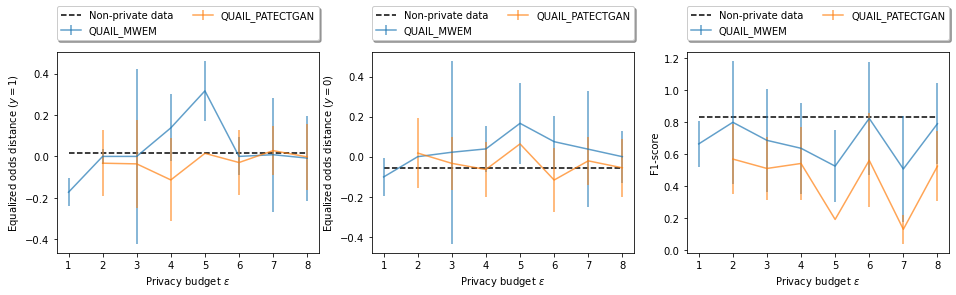

In [21]:
# Plot new MWEM results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/preprocessed/", savefig=True)

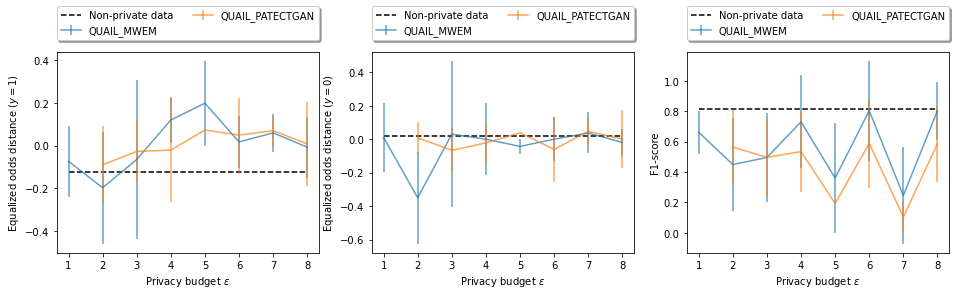

In [22]:
# Plot new MWEM results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="german", results_dir="german/preprocessed/", savefig=True)

In [23]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.022
F1-score median: 0.686


In [25]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="german", results_dir="german/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.036
FPR difference median: -0.033
F1-score median: 0.510
